## Linear Regression

In [1]:
import pandas as pd

df = pd.read_csv('../../../python-machine-learning-book-3rd-edition-master/ch10/housing.data.txt', header=None, sep='\s+')
df.columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS',
    'NOX', 'RM', 'AGE', 'DIS', 'RAD',
    'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


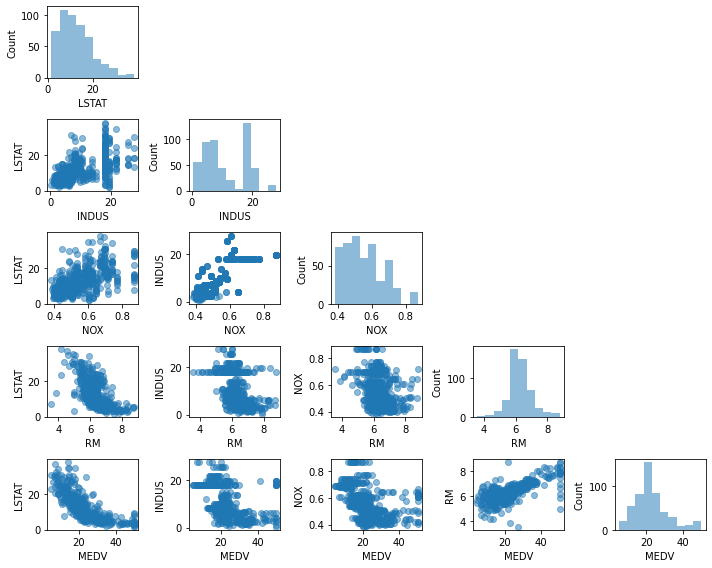

In [2]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

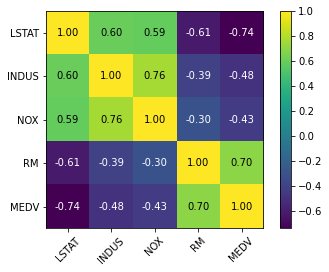

In [3]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

## Linear Least Squares

In [4]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

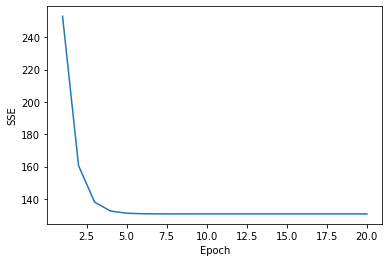

In [5]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [6]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

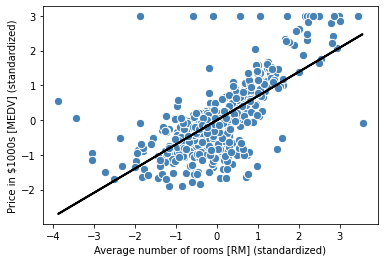

In [7]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [8]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print(f'Price in $1000s: {sc_y.inverse_transform(price_std)[0]: .3f}')

Price in $1000s:  10.840


In [9]:
print(f'Slope: {lr.w_[1]: .3f}')
print(f'Intercept: {lr.w_[0]: .3f}')

Slope:  0.695
Intercept: -0.000


In [10]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]: .3f}')
print(f'Intercept: {slr.intercept_: .3f}')

Slope:  9.102
Intercept: -34.671


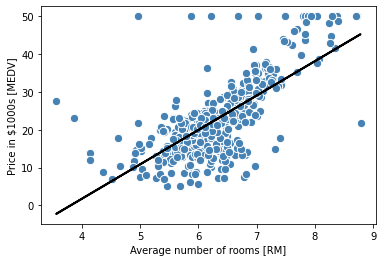

In [11]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## RANdom SAmple Consensus

In [12]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=50,
    loss='absolute_loss',
    residual_threshold=5.0,
    random_state=11111
)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=11111, residual_threshold=5.0)

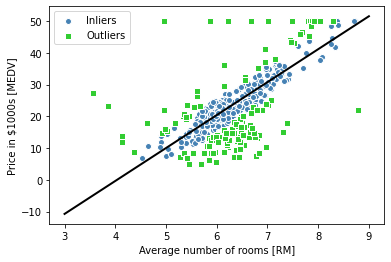

In [13]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(
    X[inlier_mask],
    y[inlier_mask],
    c='steelblue',
    edgecolor='white',
    marker='o',
    label='Inliers'
)
plt.scatter(
    X[outlier_mask],
    y[outlier_mask],
    c='limegreen',
    edgecolor='white',
    marker='s',
    label='Outliers'
)
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='best')
plt.show()

In [14]:
print(f'Slope: {ransac.estimator_.coef_[0]: .3f}')
print(f'Intercept: {ransac.estimator_.intercept_: .3f}')

Slope:  10.374
Intercept: -41.851


## Residual Plot

In [16]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11111)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

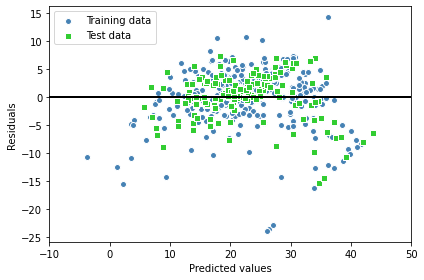

In [18]:
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='steelblue',
    marker='o',
    edgecolor='white',
    label='Training data'
)
plt.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='limegreen',
    marker='s',
    edgecolor='white',
    label='Test data'
)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='best')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

print(f'MSE train: {mean_squared_error(y_train, y_train_pred): .3f}, test: {mean_squared_error(y_test, y_test_pred): .3f}')

MSE train:  24.543, test:  16.812


In [20]:
from sklearn.metrics import r2_score

print(f'R^2 train: {r2_score(y_train, y_train_pred): .3f}, test: {r2_score(y_test, y_test_pred): .3f}')

R^2 train:  0.707, test:  0.804


## Polynomial Regression

In [21]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([
    258.0, 270.0, 294.0,
    320.0, 342.0, 368.0,
    396.0, 446.0, 480.0,
    586.0
])[:, np.newaxis]

y = np.array([
    236.4, 234.4, 252.8,
    298.6, 314.2, 342.2,
    360.8, 368.0, 391.2,
    390.8
])

lr = LinearRegression()
pr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

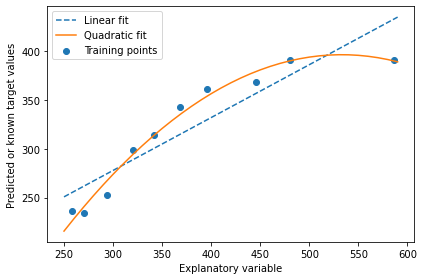

In [22]:
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print(f'Training MSE linear: {mean_squared_error(y, y_lin_pred): .3f}, quadratic: {mean_squared_error(y, y_quad_pred): .3f}')
print(f'Training R^2 linear: {r2_score(y, y_lin_pred): .3f}, quadratic: {r2_score(y, y_quad_pred): .3f}')

Training MSE linear:  569.780, quadratic:  61.330
Training R^2 linear:  0.832, quadratic:  0.982
